# Optimization of a robotic crane
### *Department meeting May 2022 edition*

Optimization is an important area in robotics. Methods and algorithms for optimization helps us to increase performance and accuracy and reduce energy usage in robot operations. In this hands-on exercise we give an example on how optimization can be used in robotics and some of the important aspects of optimization – such as "cost functions" and "constraints". You'll learn about cost functions, constraints and more in the rest of this exercise.

**Learning goals:**  
- Understand how a <mark>mathematical model</mark> of a robot can be used to produce optimal control algorithms for planning and control.
- Understand the concept of <mark>cost functions</mark> and <mark>constraints</mark> in optimization problems and how they are used.
- Familiarize with how to use an optimization solver and do iterative design of a trajectory optimization problem.

---

<div class="alert alert-block alert-info">
<b>Note:</b> This is an online Jupyter notebook. Notebooks integrate Python code, text and plots in a single convenient file, split into "cells".
Use the "Run" button (or shift+enter) to step through the code below. It is important that ALL cells are run in sequence.
We use the Binder service to launch the notebook online, such that we can run Python code remotely in the cloud.

If the notebook is inactive for some time the process that runs the notebook will disconnect and you will get a "kernel dead" message (this is because the code runs on a server in the cloud somewhere and disconnect to free up resources if you are not using it). If this happens, just simply press "restart" and run through the code from the top again.
</div>

---

Before proceeding we first need to run some start up code:

In [207]:
# Enable nice plots:
%matplotlib inline

# Imports:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib import rcParams, animation
import casadi as cs
from IPython.display import HTML

# Some CSS style:
HTML("""
<style>
.output_subarea {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
.square-container {
  display: flex;
  flex-wrap: wrap;
  margin-top: 15px;
}
.square {
  position: relative;
  flex-basis: calc(20% - 10px);
  margin: 5px;
}
.square::before {
  content: '';
  display: block;
  padding-top: 100%;
}
.square .content {
  position: absolute;
  top: 0; left: 0;
  height: 100%;
  width: 100%;

}
</style>
""")

### Introducing the problem:
We will be studying an overhead crane operating from the ceiling of a production facility. The crane is big and heavy, and it is therefore important that the tip of the crane is accurately controlled such that we get fast, safe and efficient production.

To this end we will consider using <mark>trajectory optimization</mark> to plan the motion of the overhead crane. The crane has an overhead cart with horizontal position $r$ and an angle $\theta$ down to the payload of the crane, as seen in the figure below. The cart has velocity $\dot{r}$ and the payload has angular velocity $\dot{\theta}$. We let $x = [r \ \theta \ \dot{r} \ \dot{\theta}]^\top$ be the "states" of our system which we want to control. We can push the cart with a force $F$ and we will try to find a way to determine $F$ over time such that we move the crane system from the "Start" position to the "Target" position in a smooth and efficient way.

<img src="crane_fig.png" alt="crane" width="800"/>

The crane pendulum has length $\ell$, the mass of the cart is $m_1$, the mass of the load is $m_2$ and the gravity is $g$.

## Trajectory optimization:

<div class="alert alert-block alert-info">
<b>Trajectory optimization, briefly:</b>
Optimization is concerned with minimizing/maximizing some function (subsequently called a cost function), while adhering to constraints. In trajectory optimization we apply optimization to find some optimal trajectory/path for a system, such as a robot, drone, rocket, or in our case an autonomous crane. By designing an optimization problem that tries to optimize some performance metric for the system, while considering the dynamics of our system and possible additional constraints, we can generate stable, smooth and safe motions for our system. 
</div>

<div class="square-container">
  <div class="square">
    <div class="content">
      <img src="img/anymal.jpg"/>
    </div>
  </div>

  <div class="square">
    <div class="content spread">
      <img src="img/dragon.jpg"/>
    </div>
  </div>

  <div class="square">
    <div class="content column">
      <img src="img/quadcopter.jpg"/>
    </div>
  </div>

  <div class="square">
    <div class="content spread">
      <img src="img/panda.jpg"/>
    </div>
  </div>

  <div class="square">
    <div class="content column">
      <img src="img/soft.jpg"/>
    </div>
  </div>
</div>

*Different dynamical systems whose motion trajectories are often planned using trajectory optimization. Quadruped(credit: Bjelonic et al., Whole-Body MPC and Online Gait Sequence Generation for Wheeled-Legged Robots, 2021), spacecraft, quadcopter, robot manipulator arm(credit: Franka Emika), soft foam robot(credit: Bern et al., Trajectory Optimization for Cable-Driven Soft Robot Locomotion, 2019).*


For our first example we will simply tell the optimizer to minimize the distance to the target position, while penalizing high velocities. We write this mathematically with the cost function
$$J = R_r (r - r_t)^2 + R_\theta \theta^2 + R_{\dot{r}} \dot{r}^2 + R_{\dot{\theta}} \dot{\theta}^2.$$

Since this function is to be minimized, the optimization system will simultaneously try to bring the horizontal position of the cart $r$ to the target $r_t$, while also bringing the angle $\theta$ to the down position (zero). $R_r$ and $R_\theta$ are weights that describe how we weigh these two goals against each other. I.e., if $R_r$ is much bigger than $R_\theta$, then the crane trajectory optimizer will prioritize getting the cart to the target position, and give less priority to getting the crane angle to zero. Small penalities are also added on the velocities $ \dot{r}$ and $\dot{\theta}^2$ with weights $R_{\dot{r}}$ and $R_{\dot{\theta}}$ to make the solutions to the problem more unique.

We will minimize this cost function over a time horizon of 4 seconds – i.e., our crane trajectory optimizer will look up to 4 seconds into the future and optimize the crane movement for this time period.

The complete optimization problem will then look like this:
\begin{aligned}
    \min_{u} \quad & \sum_{i=0}^{N-1}{R_r (r_i - r_t)^2 + R_\theta \theta_i^2} + R_{\dot{r}} \dot{r}_i^2 + R_{\dot{\theta}} \dot{\theta}_i^2 \\
    \textrm{s.t.} \quad & x_{k+1} = f_d(x_k, u_k) \quad \forall k = 0, 1, \dots, N-1 \\
    & x_0 = x(0)    \\
\end{aligned}
We optimize our cost function over a duration of $N$ time steps, while adhering to the dynamics of our system given by the function $f_d$. We also add the constraint $x_0 = x(0)$ to make sure our solution starts in the initial condition $x(0)$.

An important part of the optimization problem above is understanding how our system will behave using $f_d$. To this end, we need to make a mathematical model of the crane system. This mathematical model is given to our optimizer, such that it can take into account how the crane will move while it plans.

---

### Model:
The mathematical model of our crane system will first be defined. It can be expressed in the form:
$$M(\theta) \begin{bmatrix}\ddot{r} \\ \ddot{\theta} \end{bmatrix} + h(\theta, \dot{\theta}) = u.$$
The details of the model are not important for understanding the rest of the exercise. However, for completeness, it can be shown that the mass matrix $M$ is:
$$M(\theta) = \begin{bmatrix} m_1 + m_2 & m_2 \ell \cos(\theta) \\ m_2 \ell \cos(\theta) & m_2 \ell^2 \end{bmatrix},$$
the vector for the Coriolis and gravitational terms $h$ is:
$$\quad h(\theta, \dot{\theta}) = \begin{bmatrix} -m_2 \ell \dot{\theta}^2 \sin{\theta} \\ m_2 g \ell \sin{\theta} \end{bmatrix}$$
and the control input to our system $u$, i.e., the variable which we can use to control the motion of our crane system, is:
$$\quad u = \begin{bmatrix} F \\ 0 \end{bmatrix}.$$

In order to simulate our system we rewrite it with respect to the accelerations:
$$\begin{bmatrix}\ddot{r} \\ \ddot{\theta} \end{bmatrix} = M(\theta)^{-1} \left(u - h(\theta, \dot{\theta})\right).$$
This equation can then be included as a constraint in an optimization problem in order to find physically feasible motions. 

---

Now let's add some code to solve this optimization problem. ***There is no need to read through the code to follow the main aspects this hands-on exercise.***

In this exercise, we will use CasADi (https://web.casadi.org/), an open-source tool for solving optimal control problems. In order to compute derivatives of complex, nonlinear expressions, CasADi uses a symbolic framework that implements both forward and backward automatic differentiation.

We start by setting up the necessary variables and functions for describing the dynamics of the problem.

In [208]:
# Create symbolic variables for the state variables and input variable:
r = cs.SX.sym("r")                          # Position of cart
theta = cs.SX.sym("theta")                  # Angle of pendulum
r_dot = cs.SX.sym("r_dot")                  # Velocity of cart
theta_dot = cs.SX.sym("theta_dot")          # Angular velocity of pendulum
x = cs.vertcat(r, theta, r_dot, theta_dot)  # x is the vector of the four states: x = [r, theta, r_dot, theta_dot]
u = cs.SX.sym("F")                          # u is the input, i.e., the force F

# Parameters:
m_1 = 5.0           # mass of the cart
m_2 = 1.0           # mass of the load
l = 1.0             # length of the pendulum
grav = 9.81            # gravity
r_pendulum = 0.08   # radius of the circular load (not used in model but used later)

def generate_cont_dynamics(m_1, m_2, l, g):
    # Inverse mass matrix:
    M_inv = cs.SX(2,2)
    M_inv[0,0] = m_2 * l**2
    M_inv[0,1] = -m_2 * l * cs.cos(theta)
    M_inv[1,0] = -m_2 * l * cs.cos(theta)
    M_inv[1,1] = m_1 + m_2
    M_inv = M_inv / ((m_1+m_2) * m_2 * l**2 - m_2**2 * l**2 * cs.cos(theta)**2)

    # Vector of gravity + coriolis terms:
    h = cs.SX(2,1)
    h[0,0] = -m_2 * l * theta_dot**2 * cs.sin(theta)
    h[1,0] = m_2 * l * g * cs.sin(theta)

    x_dot = cs.vertcat(x[2:], M_inv @ (cs.vertcat(u, 0)-h))  # formulate dynamics (time derivatives of states)
    f = cs.Function("f", [x, u], [x_dot])
    return f

# We integrate the dynamics one time step dt into the future using the 4th order Runge-Kutta method
# in order to get a model that can be included in the optimization problem:
def integrate_RK4(x_k, u_k, f, dt):
    k1 = f(x_k, u_k)
    k2 = f(x_k + dt * k1 / 2.0, u_k)
    k3 = f(x_k + dt * k2 / 2.0, u_k)
    k4 = f(x_k + dt * k3, u_k)
    return x_k + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

def generate_disc_dynamics(m_1, m_2, l, g, dt):
    f = generate_cont_dynamics(m_1, m_2, l, g)
    f_d = cs.Function("f", [x, u], [integrate_RK4(x, u, f, dt)])  # discrete dynamics
    return f_d

dt = 0.05  # optimizer time step
f = generate_cont_dynamics(m_1, m_2, l, grav)
f_d = generate_disc_dynamics(m_1, m_2, l, grav, dt)

The optimization problem is then written down using CasADi.

<div class="alert alert-block alert-info">
<details>
<summary><b>Short (optional) explanation of CasADi code</b> (click me)</summary>

In CasADi, optimization variables are defined as `cs.SX.sym` objects. We need to define the cost function and constraints as symbolic expressions of these variables. This was done at the top of the previous code block to define symbolic variables for the state variables $r, \theta, \dot{r}, \dot{\theta}$ and the input force $F$.

The optimization problem is formulated as a nonlinear program (NLP) of the form
$$
\begin{aligned}
    \min_{x} \quad & f(x) \\
    \textrm{s.t.} \quad & x_\textrm{lb} \leq x \leq x_\textrm{ub}, \\
    & g_\textrm{lb} \leq g(x) \leq g_\textrm{ub}. \\
\end{aligned}
$$
Meaning we try to find the optimal value of $x$ that minimizes the nonlinear function $f$ while ensuring $x$ stays within the bounds $[x_\textrm{lb}, x_\textrm{ub}]$ and the nonlinear function $g$ stays within the bounds $[g_\textrm{lb}, g_\textrm{ub}]$.

In order to formulate our optimization problem to this form we have to iterate over all the $N$ time steps and 1. compute the current state $x_k$ using our dynamics function $f_d$, 2. compute the cost at the current step using the cost function $J$ and 3. add any additional constraints.

When $f$, $x$ and $g$ are formulated using the symbolic variables, an NLP solver is created using `cs.nlpsol()` and this solver is called to solve the optimization problem.
</details>
</div>

In [209]:
N = 80      # number of control segments
r_t = 0.5   # target position

def optimize_crane(f_d, N, x_0, r_t, R_F=0, use_term_constraint=False, F_max=None, theta_max=None, opts={}):
    # N:   Number of control segments
    # x_0: Initial state
    # r_t: Terminal position
    # Weights:
    R_r = 100
    R_theta = 100
    R_r_dot = 1
    R_theta_dot = 1
    # Maximum and minimum force
    if F_max is None: F_max = cs.inf

    # Cost function (syntax: cs.Function(name, variables, expression))
    J_k = cs.Function("J_k", [x, u], [R_r*(x[0] - r_t)**2 + R_theta*x[1]**2 + R_r_dot*r_dot**2 + R_theta_dot*theta_dot**2 + R_F*u**2])
    
    # Start with an empty NLP (nonlinear program):
    U = []            # Control
    U_0 = np.zeros(N) # Initial guess
    lbu = []          # Control lower bound
    ubu = []          # Control upper bound
    J = 0             # Cost
    g = []            # Constraint
    lbg = []          # Constraint lower bound 
    ubg = []          # Constraint upper bound

    X_k = cs.SX(x_0)
    for k in range(N):
        # Control input at step k:
        U_k = cs.SX.sym("U_" + str(k))
        U += [U_k]
        
        # Add control input constraints:
        lbu += [-F_max]
        ubu += [F_max]

        X_k = f_d(X_k, U_k)     # integrate to get state at time step k
        J += J_k(X_k, U_k) # add cost at time step k to cost over entire time horizon

        # Add state constraint:
        if theta_max is not None:
            g += [X_k[1]]
            lbg += [-theta_max]
            ubg += [theta_max]

    # Add terminal constraint:
    if use_term_constraint:
        g += [X_k[0] - r_t, X_k[1:]]
        lbg += [0, 0, 0, 0]
        ubg += [0, 0, 0, 0]

    # Create an NLP solver:
    nlp = {"f": J, "x": cs.vertcat(*U), "g": cs.vertcat(*g)}
    solver = cs.nlpsol("solver", "ipopt", nlp, opts)

    # Solve the NLP:
    sol = solver(x0=U_0, lbx=lbu, ubx=ubu, lbg=lbg, ubg=ubg)
    u_sol = sol["x"]
    obj = solver.stats()["iterations"]["obj"]
    return u_sol, obj

We then add some code for simulating the crane (i.e., integrate the dynamics of the crane over time based on the mathematical model of the crane we defined earlier): 

In [210]:
dt_sim = 0.005      # time step of simulation in seconds 
N_sim = 1000        # number of simulation steps 
r_0 = -0.5          # initial position
theta_0 = 0.0       # initial angle
x_0 = np.array([r_0, theta_0, 0.0, 0.0])  # Initial state (r, theta, r_dot, theta_dot)

def simulate_crane(x_0, u, N_sim):
    k_u = int(dt/dt_sim)
    x_sim = np.zeros((N_sim+1,4))
    x_sim[0,:] = x_0
    u_sim = np.zeros(N_sim)
    for k in range(N_sim):
        if k < k_u * N: u_sim[k] = u[int(k/k_u)]
        x_sim[k+1] = np.array(integrate_RK4(x_sim[k], u_sim[k], f, dt_sim)).squeeze()
    return x_sim, u_sim

Finally we need some code for visualizing the simulation results:

In [211]:
rcParams["lines.linewidth"] = 2

def plot_cost(cost):
    plt.figure(figsize=(8,4))
    plt.plot(cost, color="crimson")
    plt.yscale('log')
    plt.title("Cost function")
    plt.xlabel("Iterations")
    plt.ylabel("Cost")

def plot_results(x_sim, u_sim, F_max=None, theta_max=None):
    t = np.array([dt_sim*i for i in range(N_sim)])
    
    # Plot control input:
    fig, ax = plt.subplots(figsize=(8,4))
    ax.step(t, u_sim, where="post", c="teal")
    if F_max is not None:
        ax.plot([0, np.max(t)], F_max * np.ones(2), "--", c="darkmagenta", alpha=0.7)
        ax.plot([0, np.max(t)], -F_max * np.ones(2), "--", c="darkmagenta", alpha=0.7)
    ax.set_title("Force input")
    ax.set_xlabel(r"$t$ [s]")
    ax.set_ylabel(r"$F$ [N]")

    # Plot state variables:
    fig, ax = plt.subplots(2,2, figsize=(10,5), sharex=True)
    fig.suptitle("States")
    
    ax[0,0].plot(t, x_sim[:N_sim,0], c="mediumblue")
    ax[0,0].plot([0, np.max(t)], r_t * np.ones(2), "--", c="crimson", alpha=0.7)
    ax[0,0].set_ylabel(r"$r$ [m]")
    
    ax[0,1].plot(t, x_sim[:N_sim,1], c="mediumblue")
    ax[0,1].plot([0, np.max(t)], np.zeros(2), "--", c="crimson", alpha=0.7)
    if theta_max is not None:
        ax[0,1].plot([0, np.max(t)], theta_max * np.ones(2), "--", c="darkmagenta", alpha=0.7)
        ax[0,1].plot([0, np.max(t)], -theta_max * np.ones(2), "--", c="darkmagenta", alpha=0.7)
    ax[0,1].set_ylabel(r"$\theta$ [rad]")

    ax[1,0].plot(t, x_sim[:N_sim,2], c="mediumblue")
    ax[1,0].plot([0, np.max(t)], np.zeros(2), "--", c="crimson", alpha=0.7)
    ax[1,0].set_ylabel(r"$\dot{r}$ [m/s]")
    ax[1,0].set_xlabel(r"$t$ [s]")
    
    ax[1,1].plot(t, x_sim[:N_sim,3], c="mediumblue")
    ax[1,1].plot([0, np.max(t)], np.zeros(2), "--", c="crimson", alpha=0.7)
    ax[1,1].set_ylabel(r"$\dot{\theta}$ [rad/s]")
    ax[1,1].set_xlabel(r"$t$ [s]")
    
    fig.subplots_adjust(wspace=0.24)

    plt.show()

def show_animation(x_sim, obstacle=False):
    skips = 10
    frames = int(N_sim / skips)
    delay = skips*dt_sim*1e3

    rect_height = 0.15
    rect_width = 0.4
    beam_height = 0.05

    fig, ax = plt.subplots(figsize=(10,5))

    ax.plot([-1.2,1.2], [0,0], "k--", alpha=0.7, lw=1.5)
    ax.add_patch(Rectangle((-1, -0.5 * beam_height), 2, beam_height, facecolor="firebrick", edgecolor="k", lw=2))
    cart_rect = ax.add_patch(Rectangle((x_sim[0,0] - 0.5 * rect_width, 0.5 * rect_height), rect_width,
                                        rect_height, facecolor="indianred", edgecolor="k", lw=2))

    x_pendulum = x_sim[0,0] + l * np.sin(x_sim[0,1])
    y_pendulum = -l * np.cos(x_sim[0,1])
    load_line, = ax.plot([x_sim[0,0], x_pendulum], [0, y_pendulum], "-o", c="k", lw=3, ms=6)
    load_circle = ax.add_patch(Circle([x_pendulum, y_pendulum], radius=r_pendulum,
                                       facecolor="darkorange", edgecolor="k", lw=2))
    
    if obstacle:
        ax.add_patch(Circle(xy_obstacle, radius=r_obstacle, facecolor="orangered", edgecolor="k", lw=2))
    
    ax.plot([r_0, r_0], [-l, 0], "k--", alpha=0.7, lw=1.5)
    ax.plot([r_t, r_t], [-l, 0], "k--", alpha=0.7, lw=1.5)

    plt.axis("equal")
    plt.ylim([-l - 0.15, 0.15])

    def animate(i):
        x, theta = x_sim[skips*i,0], x_sim[skips*i,1]
        cart_rect.set_xy([x - 0.5*rect_width, -0.5*rect_height])
        
        x_pendulum = x + l * np.sin(theta)
        y_pendulum = -l * np.cos(theta)
        
        load_circle.center = [x_pendulum, y_pendulum]
        load_line.set_data([x, x_pendulum], [0, y_pendulum])
        
        return load_line, load_circle, cart_rect
    
    plt.close()

    return animation.FuncAnimation(fig, animate, frames=frames, interval=delay, blit=True)

Let's try to solve the initial problem:

In [212]:
r_0 = -0.5      # Initial position
theta_0 = 0.0   # Initial angle
N = 80          # number of control segments
r_t = 0.5       # target position

x_0 = np.array([r_0, theta_0, 0.0, 0.0])   # initial state (r, theta, r_dot, theta_dot)
F_opt, cost = optimize_crane(f_d, N, x_0, r_t)  # find the optimal force over time F_opt

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3240

Total number of variables............................:       80
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

Above you will see the output from the solver we are using(IPOPT). We can see the number of iterations the solver used, and the value of the cost (objective) function at these iterations. We also get some information about the timing of the solver.

Let's plot the cost over time as we optimize:

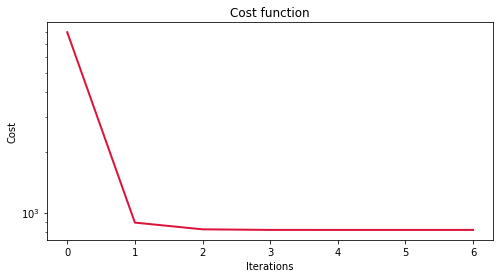

In [213]:
plot_cost(cost)

Now let's try to simulate the crane system using the force sequence we found and see how it behaves:

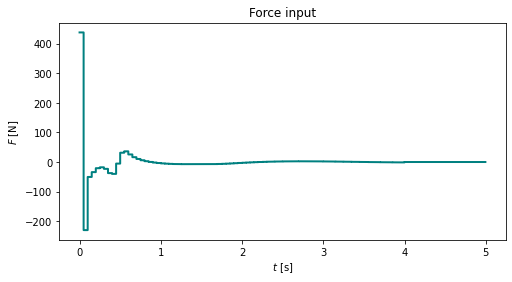

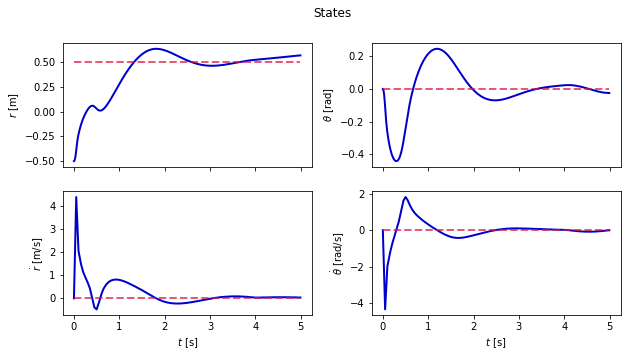

In [214]:
x_sim, u_sim = simulate_crane(x_0, F_opt, N_sim) # simulate the crane system using F_opt to control the crane
plot_results(x_sim, u_sim)                       # plot the simulation results

Run the next cell to display the crane animation (it takes a few seconds):

In [215]:
HTML(show_animation(x_sim).to_jshtml())

Let's pause here for a bit and have a look at the above plots and animation.

- The top plot ("Force input") shows the force applied to the cart-module of the crane over time.
- The two left-most figures show the position and the speed of the cart.
- The two right-most figures shows the angle and angular velocity of the payload of the crane.

So, that didn't go too well in terms of stabilizing the crane and its payload. We see from the plots that the payload of the crane does not fully stabilize in it's target position.

We also see that initially the crane jumps forward with a very large force. This would not be good for our crane and would probably not meet the safety requirements for our autonomous crane. Let's start with trying to solve this issue.

So far we have only told the optimizer to minimize the distance to the desired state of the crane system (and minimize the velocities). But we see from the above example that we should also try to minimize how large force we are using to push the cart with. This will hopefully give us smoother and safer crane motions. This can be achieved by adding the term $R_F F^2$ to the cost function. The new cost function then looks like this:
$$J = R_r (r - r_t)^2 + R_\theta \theta^2 + R_{\dot{r}} \dot{r}^2 + R_{\dot{\theta}} \dot{\theta}^2 + R_F F^2.$$

Try to change the value of the force weight $R_F$ (to e.g. 0.01, 0.1, 1, 10,...) in the code block below and see how it affects the resulting motion. Try to find a suitable value that weights the tasks against each other appropriately.


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3240

Total number of variables............................:       80
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

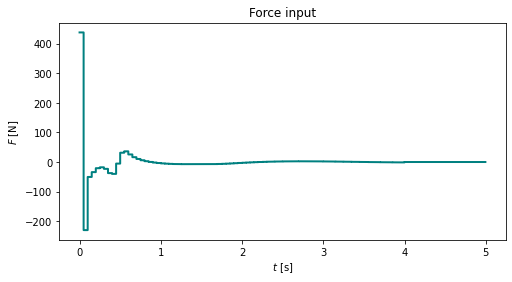

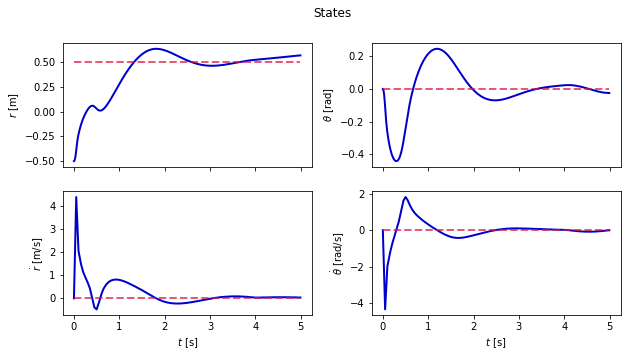

In [216]:
### Try to change the force weight and see the effect:

force_weight = 0.0

###

F_opt, cost = optimize_crane(f_d, N, x_0, r_t, R_F=force_weight)
x_sim, u_sim = simulate_crane(x_0, F_opt, N_sim)
plot_results(x_sim, u_sim)
HTML(show_animation(x_sim).to_jshtml())

Once again remember to wait for the animation...

That hopefully looks much smoother. For the remaining tests we will use a weight of 0.1.

***

## Terminal constraints:
But we have another problem: the crane pendulum doesn't hit our target exactly! It wiggles around, but ideally we want it to end perfectly at rest at its target position.

One way of solving this is to add a <mark>terminal constraint</mark>. This means that we constrain the position and angle of our crane on the final time step at $t = 4s$ to be exactly at the target, while also saying that the final velocity should be zero. This can be written like:
$$r_f = r_t, \quad \theta_f = 0, \quad \dot r_f = \dot \theta_f = 0,$$
where $r_f$ and $\theta_f$ are the final position and final angle, respectively, and $\dot r$ and $\dot \theta_f$ are the final linear and angular velocity, respectively.

Let's try out the example again, now with the terminal constraint added:

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      320
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3240

Total number of variables............................:       80
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

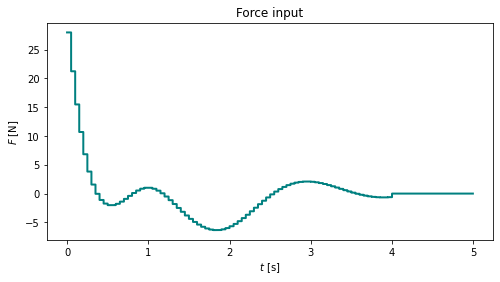

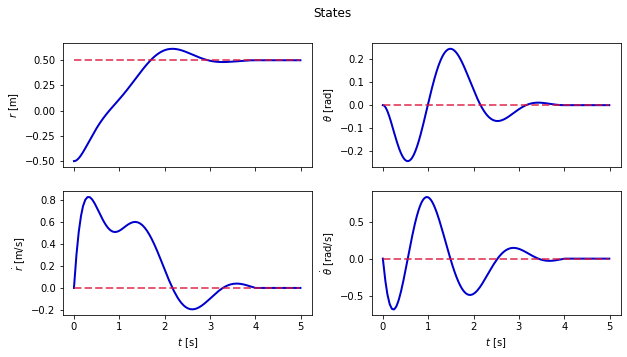

In [217]:
force_weight = 0.1
F_opt, cost = optimize_crane(f_d, N, x_0, r_t, R_F=force_weight, use_term_constraint=True)
x_sim, u_sim = simulate_crane(x_0, F_opt, N_sim)
plot_results(x_sim, u_sim)
HTML(show_animation(x_sim).to_jshtml())

<div class="alert alert-block alert-warning">
    Tip: if the output is too long, Jupyter will hide some of it. Click the leftmost part of the output box to show/hide the outputs.
</div>

---

## Input constraints:
Minimizing the input force we use over time makes the motion smoother, limits wear and tear on the actuators and facilitates more efficient operation.
This is well and good, but in many robotics we have a *finite* maximum input we can use, e.g., maximum torques on the joint of robot manipulator arm, maximum rotation speed for the rotors on a quadrotor or in our case a maximum force we can push the overhead cart with.
These limits can easily be integrated in the optimization problem as contraints:
$$-F_{\textrm{max}} \leq F \leq F_{\textrm{max}},$$
where we (arbitrarily) let $F_{\textrm{max}} = 3N$.

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      320
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3240

Total number of variables............................:       80
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       80
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

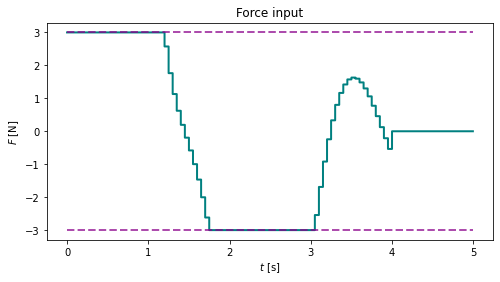

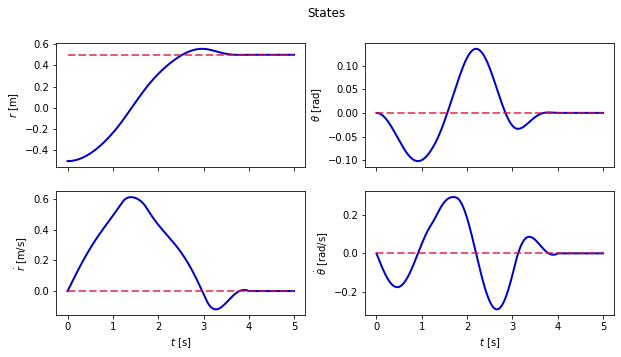

In [218]:
F_max = 3.0

F_opt, cost = optimize_crane(f_d, N, x_0, r_t, R_F=force_weight, use_term_constraint=True, F_max=F_max)
x_sim, u_sim = simulate_crane(x_0, F_opt, N_sim)
plot_results(x_sim, u_sim, F_max=F_max)
HTML(show_animation(x_sim).to_jshtml())

From the first plot we see that the force is restricted to $[-F_{\textrm{max}},F_{\textrm{max}}]$, while still achieving the main goal of reaching the target!

---

## Adding state constraints:
After adding input constraints, it would also make sense to have a look at constraints on the state variables. For instance what if we want to limit the angle $\theta$ as well? We can write the constraint like this:
$$-\theta_{\textrm{max}} \leq \theta \leq \theta_{\textrm{max}},$$
and let the maximum allowed angle be $\theta_{\textrm{max}} = 4 \ \textrm{deg}$. Let's run another example with this constraint added (instead of the input constraint):

In [219]:
# Try to vary the maximum angle
theta_max = np.deg2rad(4)

F_opt, cost = optimize_crane(f_d, N, x_0, r_t, R_F=force_weight, use_term_constraint=True, theta_max=theta_max)
x_sim, u_sim = simulate_crane(x_0, F_opt, N_sim)
plot_results(x_sim, u_sim, theta_max=theta_max)
HTML(show_animation(x_sim).to_jshtml())

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      320
Number of nonzeros in inequality constraint Jacobian.:     3240
Number of nonzeros in Lagrangian Hessian.............:     3240

Total number of variables............................:       80
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       80
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

KeyboardInterrupt: 

Nice! From the top right plot of $\theta$ we see that the angle of the crane pendulum stays within the specified limits.

---

Before moving on to the final task, feel free to play around with the different parameters to see how it affects the motion of the system in the following code block (you can change mass and length of pendulum, initial state and target state, time step, bounds on force, angle, etc...).

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      320
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3240

Total number of variables............................:       80
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

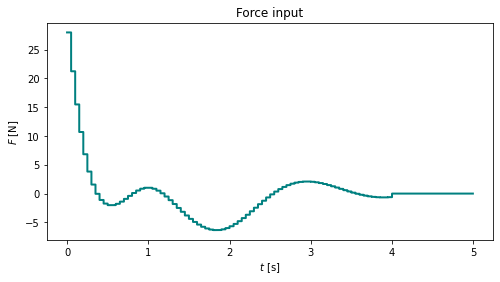

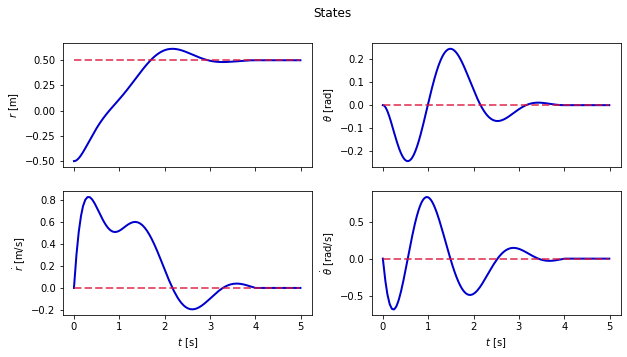

In [ ]:
# Parameters:
m_1 = 5.0           # mass of the cart
m_2 = 1.0           # mass of the load
l = 1.0             # length of the pendulum
grav = 9.81         # gravity
N = 80              # number of control segments
dt = 0.05           # time step
r_t = 0.5           # target position

r_0 = -0.5
theta_0 = 0.0
r_dot_0 = 0.0
theta_dot_0 = 0.0
x_0 = np.array([r_0, theta_0, r_dot_0, theta_dot_0])   # initial state (r, theta, r_dot, theta_dot)


f_d = generate_disc_dynamics(m_1, m_2, l, grav, dt)
F_opt, cost = optimize_crane(f_d, N, x_0, r_t, R_F=force_weight, use_term_constraint=True)
x_sim, u_sim = simulate_crane(x_0, F_opt, N_sim)
plot_results(x_sim, u_sim)
HTML(show_animation(x_sim).to_jshtml())

---

## Collision avoidance:
As a final challenge (if time permits) we will consider a simple collision avoidance example for our robotic crane. There is now a circular obstacle between the start position and goal position, with position $x_o = 0.25, y_o=-1.0$ and radius $r_o=0.1$, which we must avoid:

<img src="crane_fig_obstacle.png" alt="crane" width="800"/>

<div class="alert alert-block alert-warning">
<b>Challenge:</b> add a collision avoidance constraint to the optimization problem, such that the crane load (which is a circle with radius $r_l=0.08$) avoids the obstacle on its way to the goal position with an additional safety distance $\epsilon = 0.02$.

The CasADi code used so far is copy-pasted here for convenience. You need to add an extra constraint to the `g` variable at the indicated location in the code (have a look at the explanation of the CasADi code in the beginning of the notebook for more information). Feel free to ask for further explanation if unclear or you need some hints on where to start:) 
</div>

In [ ]:
def optimize_crane_obstacle(f_d, N, x_0, r_t, R_F=0, use_term_constraint=False, F_max=None, theta_max=None, xy_obstacle=None, r_obstacle=0.1, obstacle_eps=0.02, opts={}):
    # N:   Number of control segments
    # x_0: Initial state
    # r_t: Terminal position
    # Weights:
    R_r = 100
    R_theta = 100
    R_r_dot = 1
    R_theta_dot = 1
    # Maximum and minimum force
    if F_max is None: F_max = cs.inf

    # Cost function (syntax: cs.Function(name, variables, expression))
    J_k = cs.Function("J_k", [x, u], [R_r*(x[0] - r_t)**2 + R_theta*x[1]**2 + R_r_dot*r_dot**2 + R_theta_dot*theta_dot**2 + R_F*u**2])
    
    # Start with an empty NLP (nonlinear program):
    U = []            # Control
    U_0 = np.zeros(N) # Initial guess
    lbu = []          # Control lower bound
    ubu = []          # Control upper bound
    J = 0             # Cost
    g = []            # Constraint
    lbg = []          # Constraint lower bound 
    ubg = []          # Constraint upper bound

    X_k = cs.SX(x_0)
    for k in range(N):
        # Control input at step k:
        U_k = cs.SX.sym("U_" + str(k))
        U += [U_k]
        
        # Add control input constraints:
        lbu += [-F_max]
        ubu += [F_max]

        X_k = f_d(X_k, U_k)     # integrate to get state at time step k
        J += J_k(X_k, U_k) # add cost at time step k to cost over entire time horizon

        # Add state constraint:
        if theta_max is not None:
            g += [X_k[1]]
            lbg += [-theta_max]
            ubg += [theta_max]
        
        # Add obstacle constraint:
        if xy_obstacle is not None:
            ##### ADD OBSTACLE AVOIDANCE CONSTRAINT HERE #####
            
            
            
            ##################################################

    # Add terminal constraint:
    if use_term_constraint:
        g += [X_k[0] - r_t, X_k[1:]]
        lbg += [0, 0, 0, 0]
        ubg += [0, 0, 0, 0]

    # Create an NLP solver:
    nlp = {"f": J, "x": cs.vertcat(*U), "g": cs.vertcat(*g)}
    solver = cs.nlpsol("solver", "ipopt", nlp, opts)

    # Solve the NLP:
    sol = solver(x0=U_0, lbx=lbu, ubx=ubu, lbg=lbg, ubg=ubg)
    u_sol = sol["x"]
    obj = solver.stats()["iterations"]["obj"]
    return u_sol, obj

IndentationError: expected an indented block (Temp/ipykernel_2292/3371248756.py, line 54)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      320
Number of nonzeros in inequality constraint Jacobian.:     3240
Number of nonzeros in Lagrangian Hessian.............:     3240

Total number of variables............................:       80
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:       80
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

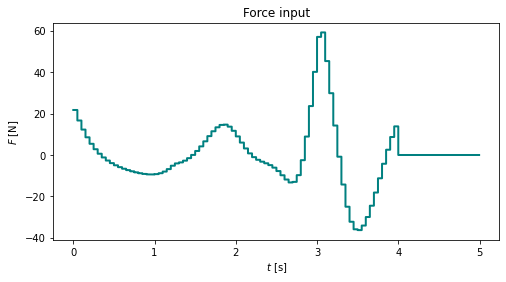

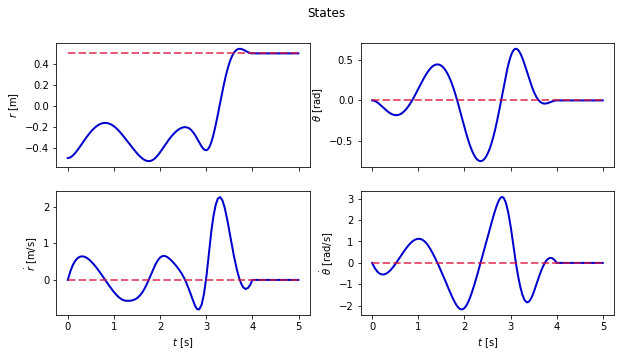

In [ ]:
xy_obstacle = [0.25,-1]
r_obstacle = 0.1
F_opt, cost = optimize_crane_obstacle(f_d, N, x_0, r_t, R_F=force_weight, use_term_constraint=True, xy_obstacle=xy_obstacle, r_obstacle=r_obstacle)
x_sim, u_sim = simulate_crane(x_0, F_opt, N_sim)
plot_results(x_sim, u_sim)
HTML(show_animation(x_sim, obstacle=True).to_jshtml())